In [1]:
import sys
sys.path.append("../../")
from pathlib import Path

import tqdm
import numpy as np
import torch

from frag.mol.mols import Mol
from frag.graph.molgraph import MolGraph, MolGraphDataset, MolGraphDataSetGenerator
from frag.fragmentation.fragmenters import BondFragmenter, AngleFragmenter
from frag.labeling.labelers import BondLabeler, AngleLabeler
from frag.featurization.atom_featurizers import RDKITFingerprint


from frag.graph.message_passing import MessagePassingBonded
from frag.graph.readout import ReadoutJanossyLinear, MLPPredictor

In [2]:
folder = Path("/dev/shm/cschlick/geostd/")
files_geo = [file for file in folder.glob("**/*") if "lib" not in  file.name  and "ccd" not in file.name and file.suffix==".cif"]

In [53]:
folder = Path("/dev/shm/cschlick/CODoutput/")
files_cod = [file for file in folder.glob("**/*") if "geo" in file.name and file.suffix==".cif"]

In [54]:
files = files_geo+files_cod

In [55]:
mols = []
debug = False
for file in tqdm.tqdm(files):
  try:
    mol = Mol.from_file_geocif(file)
    mols.append(mol)
  except:
    if debug:
      raise
  

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128518/128518 [20:15<00:00, 105.75it/s]


In [56]:
from frag.featurization.atom_featurizers import RDKITFingerprint

In [57]:
dataset_generator = MolGraphDataSetGenerator(fragmenter=AngleFragmenter(exclude_elements=[]),
                                             atom_featurizer = RDKITFingerprint(),
                                             fragment_labelers={"angle_value":AngleLabeler()},
                                             skip_hydrogens=False)

In [58]:
dataset = dataset_generator(mols)

 22%|██████████████████████████                                                                                               | 26683/123655 [08:23<19:22, 83.41it/s][21:52:28] 

****
Pre-condition Violation
bond already exists
Violation occurred on line 334 in file /home/conda/feedstock_root/build_artifacts/rdkit_1654409067822/work/Code/GraphMol/RWMol.cpp
Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
****

 30%|███████████████████████████████████▊                                                                                     | 36619/123655 [10:34<24:40, 58.78it/s][21:54:39] 

****
Pre-condition Violation
bond already exists
Violation occurred on line 334 in file /home/conda/feedstock_root/build_artifacts/rdkit_1654409067822/work/Code/GraphMol/RWMol.cpp
Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
****

 43%|████████████████████████████████████████████████████▌                                                                    | 5377

In [59]:
# set up dataset, train/test split
dataset_train, dataset_test = dataset.train_test_split(test_fraction=0.1)

In [60]:
label_name = "angle_value"
fragment_size = 3
hidden_units = 256
dropout = 0.01

atom_feature_shape = tuple(dataset[0].fragment_graph.nodes["atom"].data["h0"].shape)
message_passing = MessagePassingBonded(feature_units=atom_feature_shape[1],
                                       hidden_units=hidden_units,
                                       nlayers=4,
                                       dropout=dropout,
                                       norm = MessagePassingBonded.normalize,
                                       sage_activation=torch.nn.functional.leaky_relu)


readout = ReadoutJanossyLinear(hidden_units*fragment_size, # input units
                               hidden_units*fragment_size, # hidden units
                               n_hid_layers=2,
                               pool_func=torch.mean,
                               label_name=label_name,
                               dropout=dropout,
                               fragment_size=fragment_size)

predictor = MLPPredictor(hidden_units*fragment_size,
                         hidden_units*fragment_size,
                         2,
                         dropout=dropout,
                         label_name=label_name)
model = torch.nn.Sequential(message_passing,readout,predictor)
opt = torch.optim.Adam(model.parameters(),lr=1e-5)
def nll_loss(target, mean_pred,std_pred):
    dist = torch.distributions.Normal(mean_pred, std_pred)
    return -dist.log_prob(target)
  
metric = nll_loss
clamp_min = 0.001

In [62]:
# Training loop
gpuid = 2


if gpuid is not None:
  model = model.to("cuda:"+str(gpuid))

epoch_losses = []
n_epoch=1000
n_batches = 256
batch_size = 10 # molecules
shuffle_per_epochs=10
#batches = list(dataset_train.batches(n_batches=n_batches))
for epoch in tqdm.tqdm(range(n_epoch),desc="Epochs"):
  if epoch==0 or epoch % shuffle_per_epochs ==0:
    batches = list(dataset_train.batches(n_batches=256))
  batch_losses = []
  for bg in batches:
    
    if gpuid is not None:
      bg = bg.to("cuda:"+str(gpuid))
    g = model(bg)
    out = g.nodes["fragment"].data[label_name+"_pred"]
    mean = out[..., 0][..., None] # use first index as the mean
    std = torch.clamp(out[..., 1][..., None], min=clamp_min) # use second index as the std. Clamped positive

    data = g.nodes["fragment"].data[label_name]
    nnl = metric(data,mean,std)
    loss = nnl.sum()
    opt.zero_grad()
    loss.backward()
    opt.step()
    batch_losses.append(loss.item())

  epoch_losses.append(np.mean(batch_losses))

Epochs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [7:00:57<00:00, 25.26s/it]


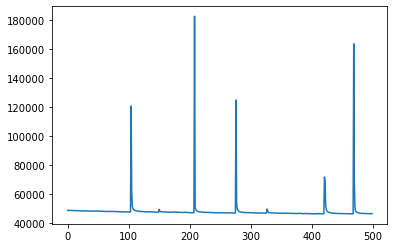

In [65]:
import matplotlib.pyplot as plt
plt.plot(epoch_losses[500:])

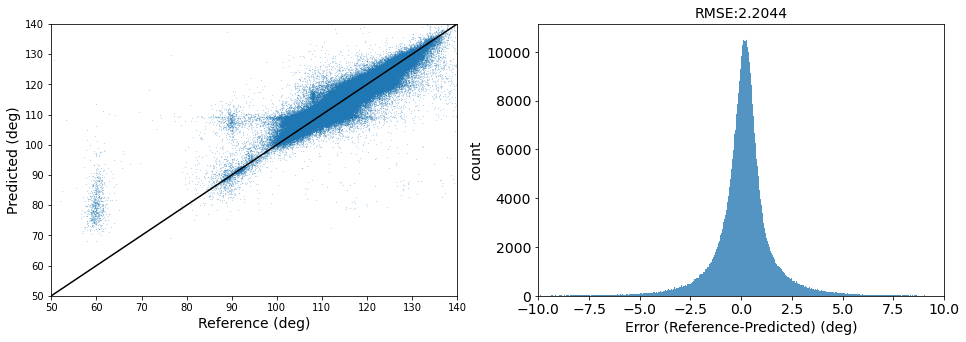

In [66]:
from frag.utils.torch import to_np, to_torch
from frag.utils.plotting import plot_geom_eval

if gpuid is not None:
  model = model.to("cpu")
test_batch = model(dataset_test.fragment_graph)
a,b = (test_batch.nodes["fragment"].data[label_name], 
       test_batch.nodes["fragment"].data[label_name+"_pred"][..., 0][..., None])
a,b = to_np(a).flatten(),to_np(b).flatten()

#a,b = np.degrees(a), np.degrees(b)
plot_geom_eval(a,b,mode="angle")

[[1.         0.68843672]
 [0.68843672 1.        ]]


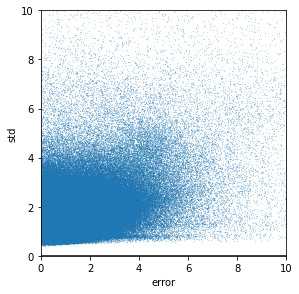

In [86]:

error_abs = np.abs(a-b)
std = test_batch.nodes["fragment"].data[label_name+"_pred"][..., 1].detach().numpy()
plt.scatter(error_abs,std,s=0.01)
plt.ylim(0,10)
plt.xlim(0,10)
plt.tight_layout()
ax = plt.gca()
ax.set_aspect('equal')
plt.xlabel("error")
plt.ylabel("std")
ax.axhline(y=clamp_min,color="black")
print(np.corrcoef(error_abs,std))

In [84]:
std

array([[0.6749248 ],
       [1.9487427 ],
       [0.66274804],
       ...,
       [1.3904623 ],
       [0.7727818 ],
       [2.2438655 ]], dtype=float32)

# Save

In [69]:
dataset_generator.pretrained_models["predictor"] = model

In [70]:
file_pkl = "../../pretrained/gnn_angles_dsgen_allatom_geostd_cod.pkl"
dataset_generator.to_file_pickle(file_pkl)

# Test inference

In [71]:
ds_gen = MolGraphDataSetGenerator.from_file_pickle(file_pkl)

In [72]:
mol_file = "/dev/shm/cschlick/CODoutput/cif/8/10/51/8105185_000_geo.cif"
mol = Mol.from_file_geocif(mol_file)
ds_inf = ds_gen(mol)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 80.07it/s]


In [73]:
model = ds_gen.pretrained_models["predictor"]
pred_graph = model(ds_inf.fragment_graph)

In [77]:
mean = to_np(test_batch.nodes["fragment"].data[label_name+"_pred"][..., 0])

array([120.243835, 119.5419  , 119.48345 , ..., 107.29422 , 119.81942 ,
       111.55101 ], dtype=float32)